In [1]:
from __future__ import division
%matplotlib inline
%pylab inline
import csv
import sys
import os
import traceback
import json
import pickle
import random
import numpy as np
import pandas as pd
import scipy.io as sio
import seaborn as sns
from scipy import stats
from scipy.signal import argrelextrema
import itertools
import scipy.fftpack as fft
from scipy.stats import norm, skew, kurtosis
from scipy.signal import butter, lfilter, filtfilt
from sklearn.externals import joblib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from collections import defaultdict, Counter, OrderedDict
from helper_functions import getListOfFiles, getCSV, getStatistics, remap_interval
from operator import itemgetter
from detect_peaks import detect_peaks
import mean_shift as ms
import mean_shift_utils as ms_utils

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from scipy.spatial.distance import cdist

class gaussian_kde(object):
    """Representation of a kernel-density estimate using Gaussian kernels.

    Kernel density estimation is a way to estimate the probability density
    function (PDF) of a random variable in a non-parametric way.
    `gaussian_kde` works for both uni-variate and multi-variate data.   It
    includes automatic bandwidth determination.  The estimation works best for
    a unimodal distribution; bimodal or multi-modal distributions tend to be
    oversmoothed.

    Parameters
    ----------
    dataset : array_like
        Datapoints to estimate from. In case of univariate data this is a 1-D
        array, otherwise a 2-D array with shape (# of dims, # of data).
    bw_method : str, scalar or callable, optional
        The method used to calculate the estimator bandwidth.  This can be
        'scott', 'silverman', a scalar constant or a callable.  If a scalar,
        this will be used directly as `kde.factor`.  If a callable, it should
        take a `gaussian_kde` instance as only parameter and return a scalar.
        If None (default), 'scott' is used.  See Notes for more details.
    weights : array_like, shape (n, ), optional, default: None
        An array of weights, of the same shape as `x`.  Each value in `x`
        only contributes its associated weight towards the bin count
        (instead of 1).

    Attributes
    ----------
    dataset : ndarray
        The dataset with which `gaussian_kde` was initialized.
    d : int
        Number of dimensions.
    n : int
        Number of datapoints.
    neff : float
        Effective sample size using Kish's approximation.
    factor : float
        The bandwidth factor, obtained from `kde.covariance_factor`, with which
        the covariance matrix is multiplied.
    covariance : ndarray
        The covariance matrix of `dataset`, scaled by the calculated bandwidth
        (`kde.factor`).
    inv_cov : ndarray
        The inverse of `covariance`.

    Methods
    -------
    kde.evaluate(points) : ndarray
        Evaluate the estimated pdf on a provided set of points.
    kde(points) : ndarray
        Same as kde.evaluate(points)
    kde.pdf(points) : ndarray
        Alias for ``kde.evaluate(points)``.
    kde.set_bandwidth(bw_method='scott') : None
        Computes the bandwidth, i.e. the coefficient that multiplies the data
        covariance matrix to obtain the kernel covariance matrix.
        .. versionadded:: 0.11.0
    kde.covariance_factor : float
        Computes the coefficient (`kde.factor`) that multiplies the data
        covariance matrix to obtain the kernel covariance matrix.
        The default is `scotts_factor`.  A subclass can overwrite this method
        to provide a different method, or set it through a call to
        `kde.set_bandwidth`.

    Notes
    -----
    Bandwidth selection strongly influences the estimate obtained from the KDE
    (much more so than the actual shape of the kernel).  Bandwidth selection
    can be done by a "rule of thumb", by cross-validation, by "plug-in
    methods" or by other means; see [3]_, [4]_ for reviews.  `gaussian_kde`
    uses a rule of thumb, the default is Scott's Rule.

    Scott's Rule [1]_, implemented as `scotts_factor`, is::

        n**(-1./(d+4)),

    with ``n`` the number of data points and ``d`` the number of dimensions.
    Silverman's Rule [2]_, implemented as `silverman_factor`, is::

        (n * (d + 2) / 4.)**(-1. / (d + 4)).

    Good general descriptions of kernel density estimation can be found in [1]_
    and [2]_, the mathematics for this multi-dimensional implementation can be
    found in [1]_.

    References
    ----------
    .. [1] D.W. Scott, "Multivariate Density Estimation: Theory, Practice, and
           Visualization", John Wiley & Sons, New York, Chicester, 1992.
    .. [2] B.W. Silverman, "Density Estimation for Statistics and Data
           Analysis", Vol. 26, Monographs on Statistics and Applied Probability,
           Chapman and Hall, London, 1986.
    .. [3] B.A. Turlach, "Bandwidth Selection in Kernel Density Estimation: A
           Review", CORE and Institut de Statistique, Vol. 19, pp. 1-33, 1993.
    .. [4] D.M. Bashtannyk and R.J. Hyndman, "Bandwidth selection for kernel
           conditional density estimation", Computational Statistics & Data
           Analysis, Vol. 36, pp. 279-298, 2001.

    Examples
    --------
    Generate some random two-dimensional data:

    >>> from scipy import stats
    >>> def measure(n):
    >>>     "Measurement model, return two coupled measurements."
    >>>     m1 = np.random.normal(size=n)
    >>>     m2 = np.random.normal(scale=0.5, size=n)
    >>>     return m1+m2, m1-m2

    >>> m1, m2 = measure(2000)
    >>> xmin = m1.min()
    >>> xmax = m1.max()
    >>> ymin = m2.min()
    >>> ymax = m2.max()

    Perform a kernel density estimate on the data:

    >>> X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    >>> positions = np.vstack([X.ravel(), Y.ravel()])
    >>> values = np.vstack([m1, m2])
    >>> kernel = stats.gaussian_kde(values)
    >>> Z = np.reshape(kernel(positions).T, X.shape)

    Plot the results:

    >>> import matplotlib.pyplot as plt
    >>> fig = plt.figure()
    >>> ax = fig.add_subplot(111)
    >>> ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
    ...           extent=[xmin, xmax, ymin, ymax])
    >>> ax.plot(m1, m2, 'k.', markersize=2)
    >>> ax.set_xlim([xmin, xmax])
    >>> ax.set_ylim([ymin, ymax])
    >>> plt.show()

    """
    def __init__(self, dataset, bw_method=None, weights=None):
        self.dataset = np.atleast_2d(dataset)
        if not self.dataset.size > 1:
            raise ValueError("`dataset` input should have multiple elements.")
        self.d, self.n = self.dataset.shape
            
        if weights is not None:
            self.weights = weights / np.sum(weights)
        else:
            self.weights = np.ones(self.n) / self.n
            
        # Compute the effective sample size 
        # http://surveyanalysis.org/wiki/Design_Effects_and_Effective_Sample_Size#Kish.27s_approximate_formula_for_computing_effective_sample_size
        self.neff = 1.0 / np.sum(self.weights ** 2)

        self.set_bandwidth(bw_method=bw_method)

    def evaluate(self, points):
        """Evaluate the estimated pdf on a set of points.

        Parameters
        ----------
        points : (# of dimensions, # of points)-array
            Alternatively, a (# of dimensions,) vector can be passed in and
            treated as a single point.

        Returns
        -------
        values : (# of points,)-array
            The values at each point.

        Raises
        ------
        ValueError : if the dimensionality of the input points is different than
                     the dimensionality of the KDE.

        """
        points = np.atleast_2d(points)

        d, m = points.shape
        if d != self.d:
            if d == 1 and m == self.d:
                # points was passed in as a row vector
                points = np.reshape(points, (self.d, 1))
                m = 1
            else:
                msg = "points have dimension %s, dataset has dimension %s" % (d,
                    self.d)
                raise ValueError(msg)

        # compute the normalised residuals
        chi2 = cdist(points.T, self.dataset.T, 'mahalanobis', VI=self.inv_cov) ** 2
        # compute the pdf
        result = np.sum(np.exp(-.5 * chi2) * self.weights, axis=1) / self._norm_factor

        return result

    __call__ = evaluate

    def scotts_factor(self):
        return np.power(self.neff, -1./(self.d+4))

    def silverman_factor(self):
        return np.power(self.neff*(self.d+2.0)/4.0, -1./(self.d+4))

    #  Default method to calculate bandwidth, can be overwritten by subclass
    covariance_factor = scotts_factor

    def set_bandwidth(self, bw_method=None):
        """Compute the estimator bandwidth with given method.

        The new bandwidth calculated after a call to `set_bandwidth` is used
        for subsequent evaluations of the estimated density.

        Parameters
        ----------
        bw_method : str, scalar or callable, optional
            The method used to calculate the estimator bandwidth.  This can be
            'scott', 'silverman', a scalar constant or a callable.  If a
            scalar, this will be used directly as `kde.factor`.  If a callable,
            it should take a `gaussian_kde` instance as only parameter and
            return a scalar.  If None (default), nothing happens; the current
            `kde.covariance_factor` method is kept.

        Notes
        -----
        .. versionadded:: 0.11

        Examples
        --------
        >>> x1 = np.array([-7, -5, 1, 4, 5.])
        >>> kde = stats.gaussian_kde(x1)
        >>> xs = np.linspace(-10, 10, num=50)
        >>> y1 = kde(xs)
        >>> kde.set_bandwidth(bw_method='silverman')
        >>> y2 = kde(xs)
        >>> kde.set_bandwidth(bw_method=kde.factor / 3.)
        >>> y3 = kde(xs)

        >>> fig = plt.figure()
        >>> ax = fig.add_subplot(111)
        >>> ax.plot(x1, np.ones(x1.shape) / (4. * x1.size), 'bo',
        ...         label='Data points (rescaled)')
        >>> ax.plot(xs, y1, label='Scott (default)')
        >>> ax.plot(xs, y2, label='Silverman')
        >>> ax.plot(xs, y3, label='Const (1/3 * Silverman)')
        >>> ax.legend()
        >>> plt.show()

        """
        if bw_method is None:
            pass
        elif bw_method == 'scott':
            self.covariance_factor = self.scotts_factor
        elif bw_method == 'silverman':
            self.covariance_factor = self.silverman_factor
        elif np.isscalar(bw_method) and not isinstance(bw_method, basestring):
            self._bw_method = 'use constant'
            self.covariance_factor = lambda: bw_method
        elif callable(bw_method):
            self._bw_method = bw_method
            self.covariance_factor = lambda: self._bw_method(self)
        else:
            msg = "`bw_method` should be 'scott', 'silverman', a scalar " \
                  "or a callable."
            raise ValueError(msg)

        self._compute_covariance()

    def _compute_covariance(self):
        """Computes the covariance matrix for each Gaussian kernel using
        covariance_factor().
        """
        self.factor = self.covariance_factor()
        # Cache covariance and inverse covariance of the data
        if not hasattr(self, '_data_inv_cov'):
            # Compute the mean and residuals
            _mean = np.sum(self.weights * self.dataset, axis=1)
            _residual = (self.dataset - _mean[:, None])
            # Compute the biased covariance
            self._data_covariance = np.atleast_2d(np.dot(_residual * self.weights, _residual.T))
            # Correct for bias (http://en.wikipedia.org/wiki/Weighted_arithmetic_mean#Weighted_sample_covariance)
            self._data_covariance /= (1 - np.sum(self.weights ** 2))
            self._data_inv_cov = np.linalg.inv(self._data_covariance)

        self.covariance = self._data_covariance * self.factor**2
        self.inv_cov = self._data_inv_cov / self.factor**2
        self._norm_factor = np.sqrt(np.linalg.det(2*np.pi*self.covariance)) #* self.n


In [3]:
acc_axes = ['x','y','z']
mat_dir = './splitting'
sym_dir = os.path.join(mat_dir)#, 'symbolization')
files = [f.split('__')[1] for f in getListOfFiles(sym_dir, ".mat")]
print ">> {} mat Files found!".format(len(files))

>> 87 mat Files found!


In [4]:
dataset = OrderedDict()
previous_files = None

for ind, current_file in enumerate(files):
    file_data = {}
    for axis in acc_axes:
        ## load correspoding data structure
        mat_content = sio.loadmat(os.path.join(sym_dir, axis+'__'+current_file))
        data = mat_content['exp']
        val = data[0,0]

        ## grab the data
        ts = [x[0] for x in val['sig_data']]
        splitpoints = val['split_cand'][0].tolist()
        weights =  val['weights'][0].tolist()

        # structuring individual axis data
        file_data[axis+'.ts'] = ts
        file_data[axis+'.splits'] = splitpoints[:-1]
        file_data[axis+'.weights'] = weights[:-1]
    dataset[current_file] = file_data
print '>> {} files loaded'.format(len(dataset.keys()))

>> 29 files loaded


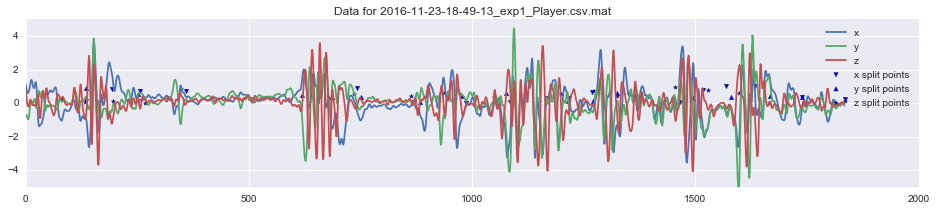

In [5]:
figsize(20,6)
file_number = 0
figsize(16,3)
markers = ['v', '^', '*']
for i,axis in enumerate(acc_axes):
    plt.plot(dataset[files[file_number]][axis+'.ts'], label= axis)
    y = np.random.rand(1,len(dataset[files[file_number]][axis+'.splits']))
    plt.scatter(dataset[files[file_number]][axis+'.splits'],y, marker=markers[i], label=axis+' split points')
plt.title('Data for ' + files[file_number])
plt.xlim(0,plt.xlim()[1])
plt.ylim(-5,5)
plt.legend()
plt.show()

## getting the separation points

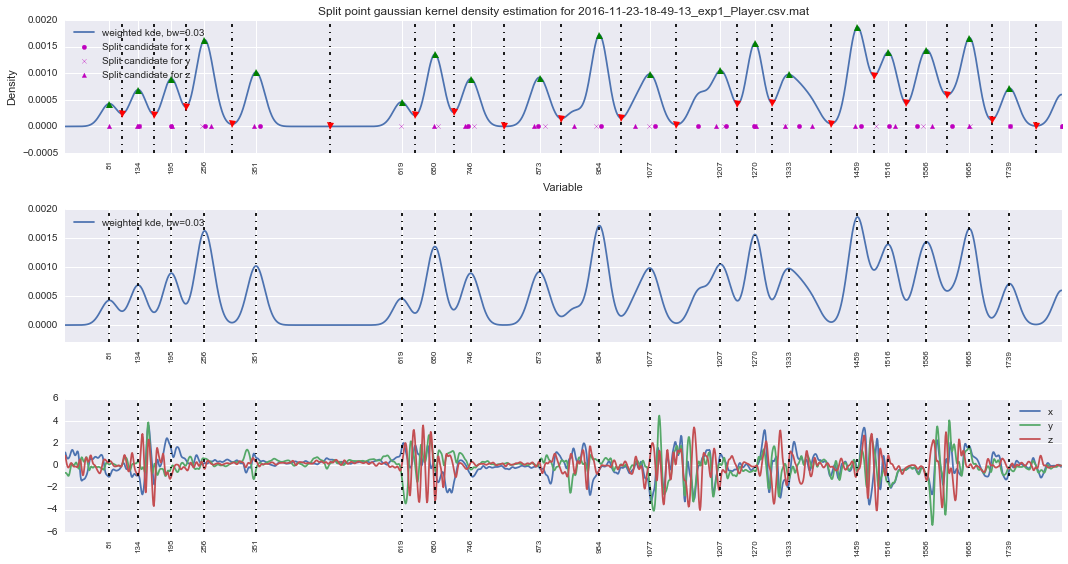

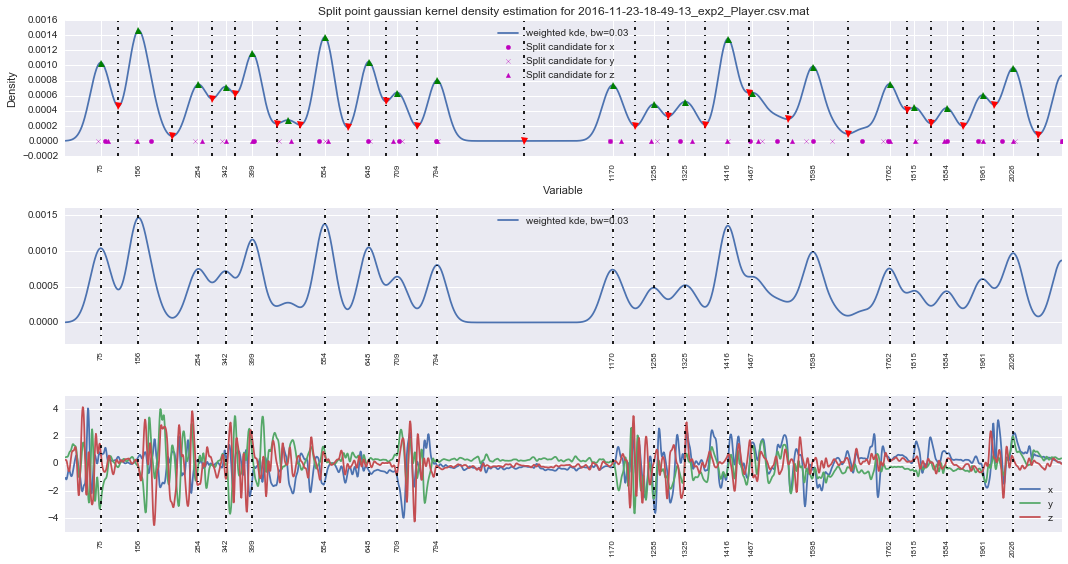

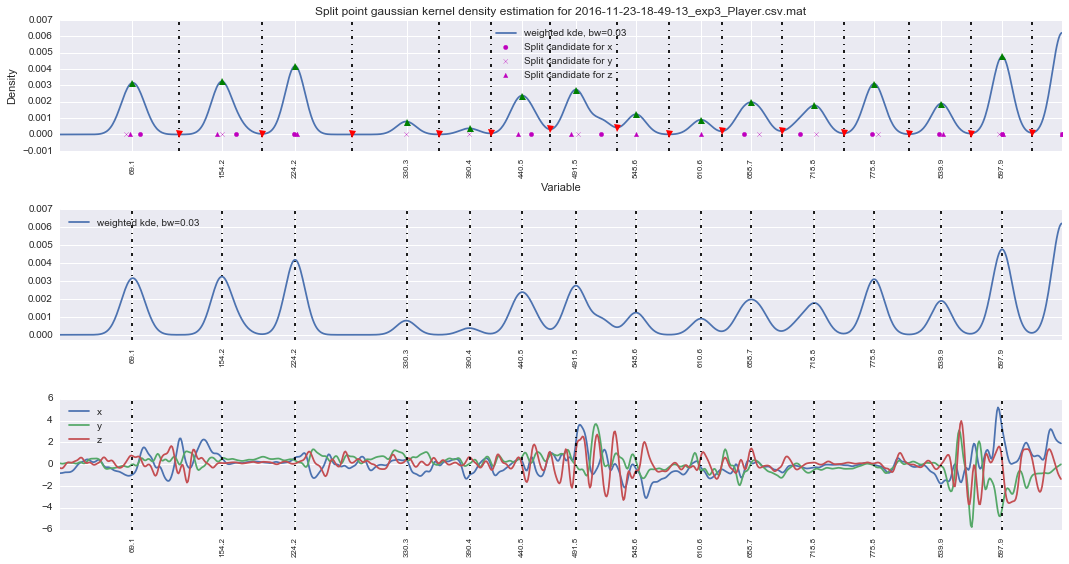

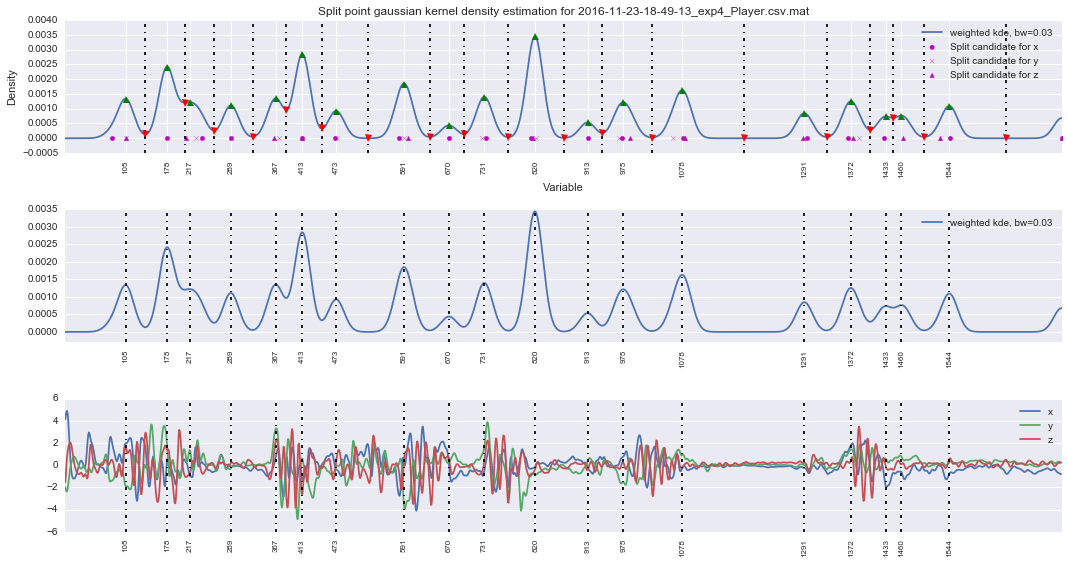

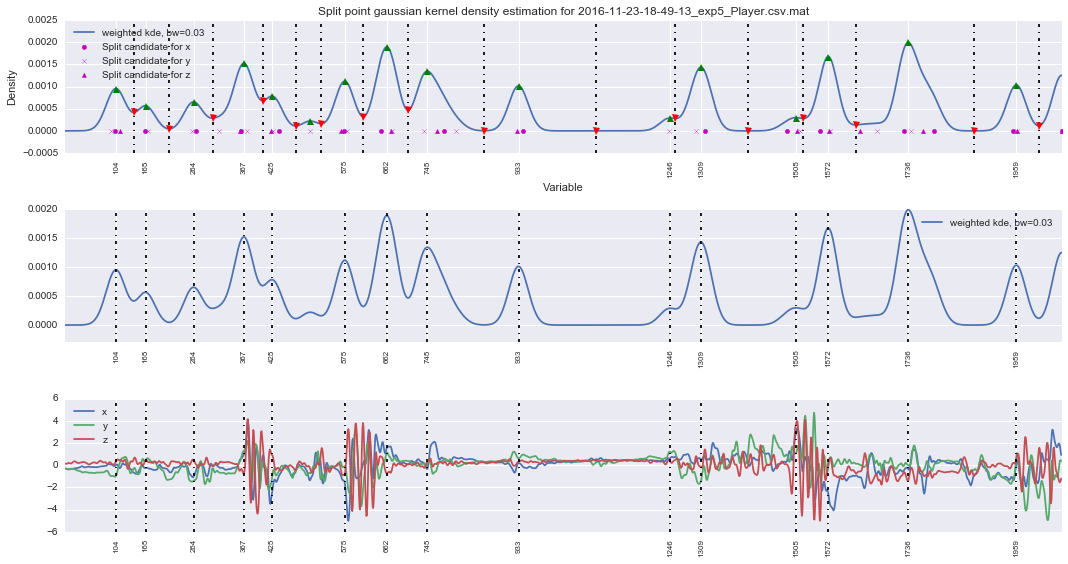

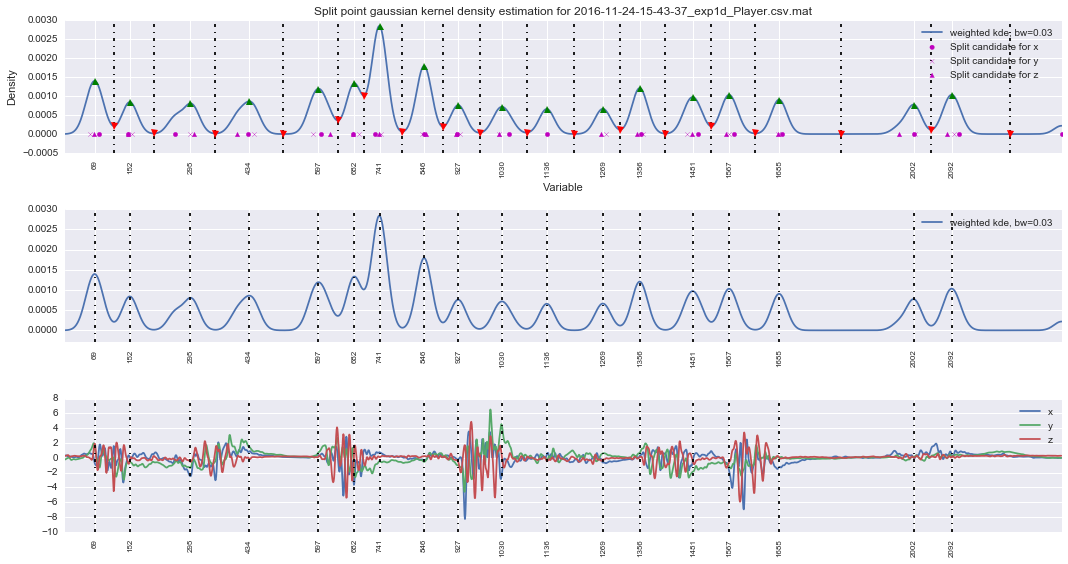

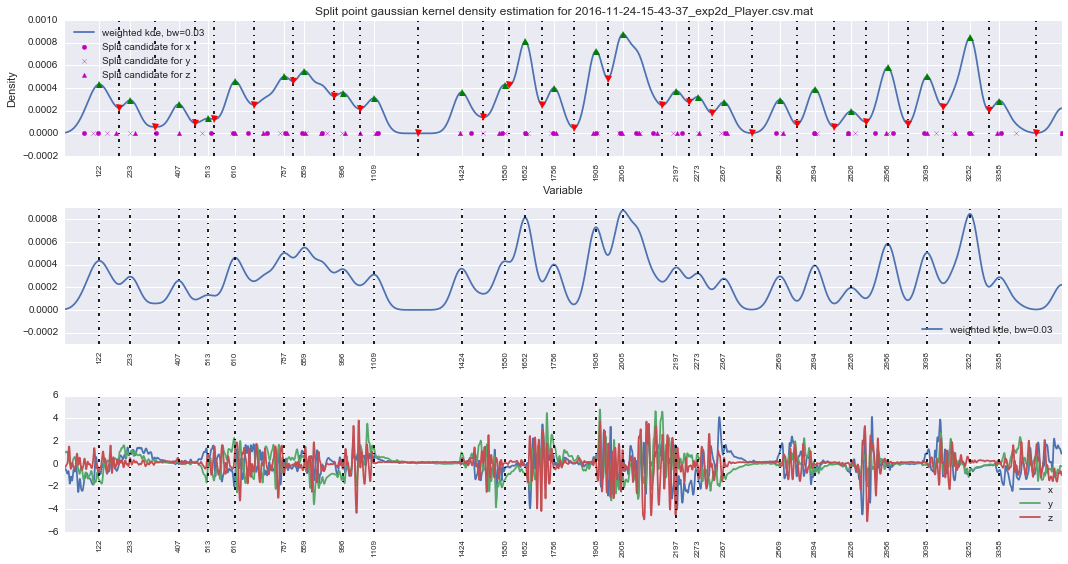

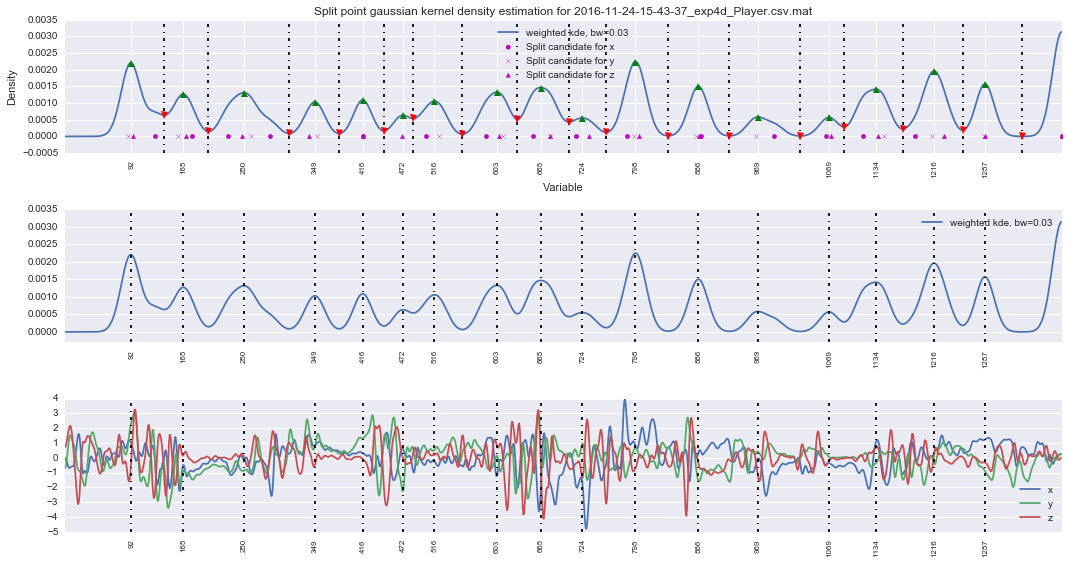

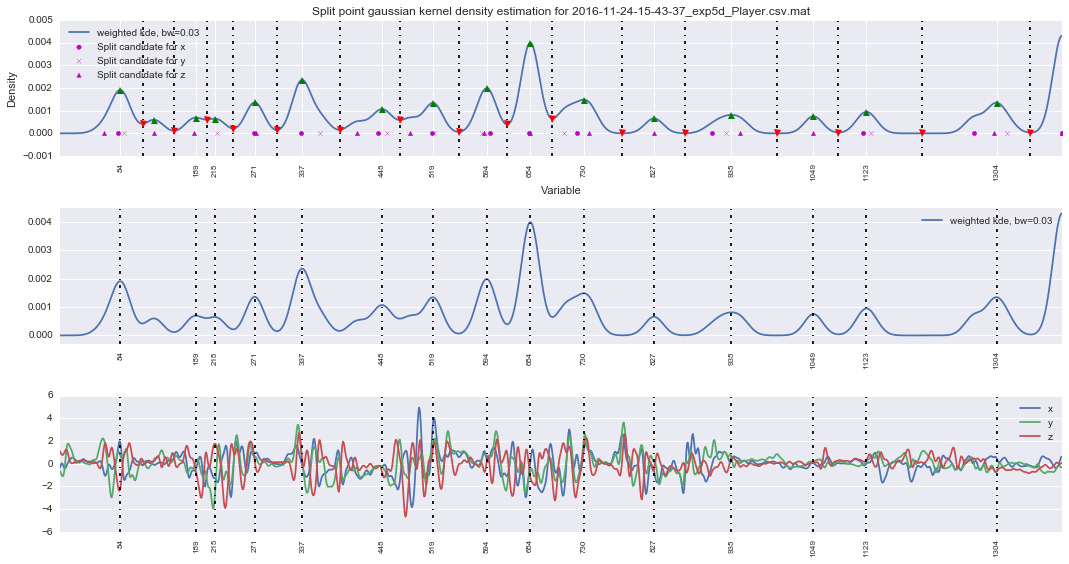

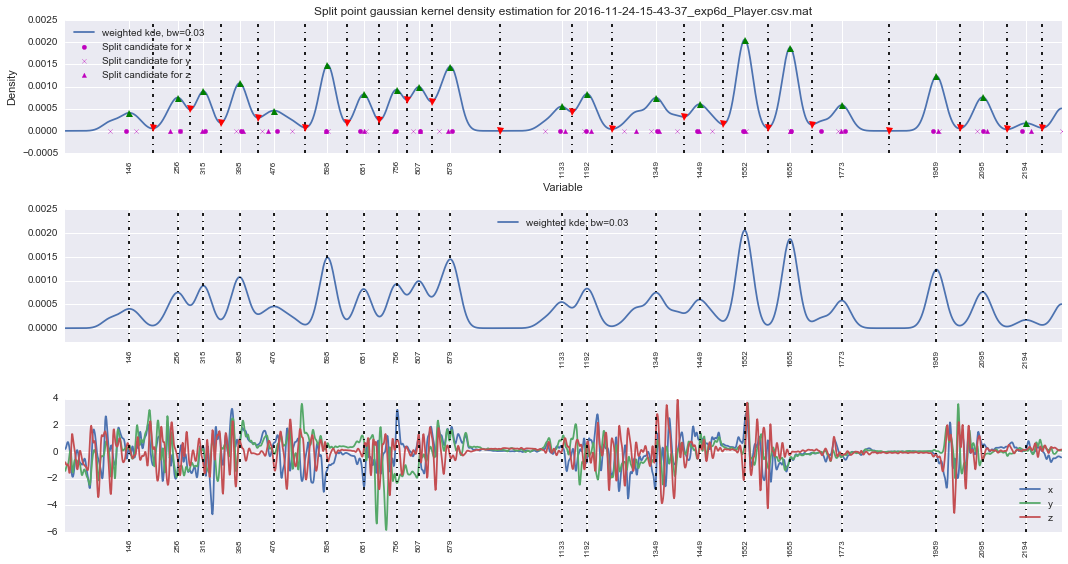

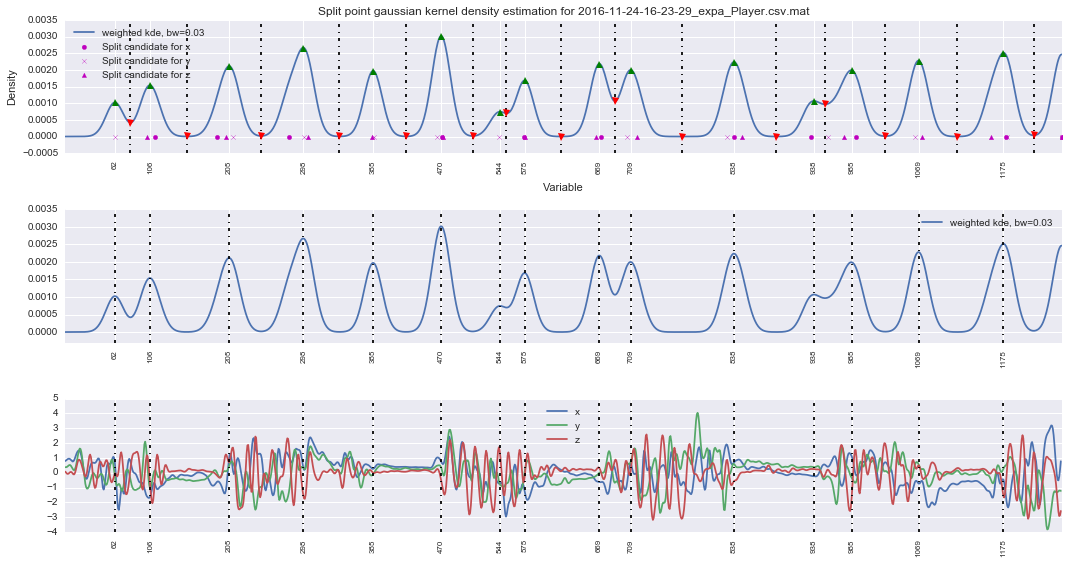

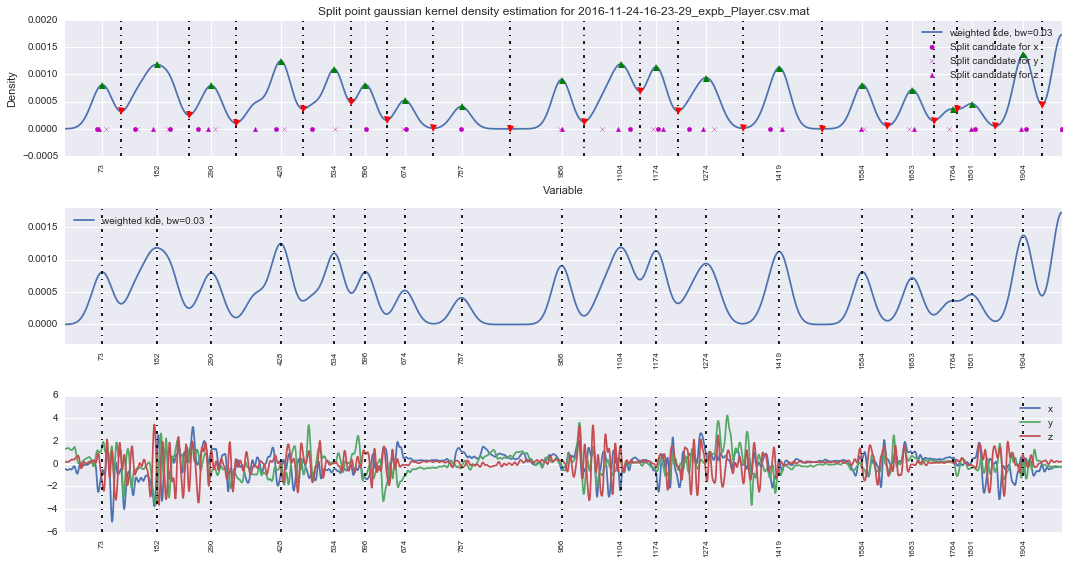

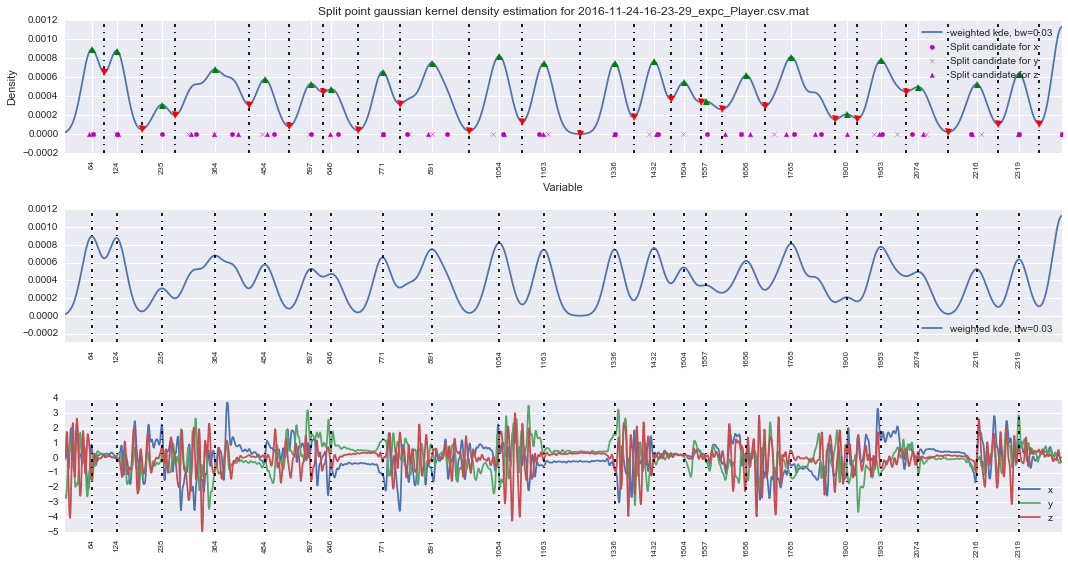

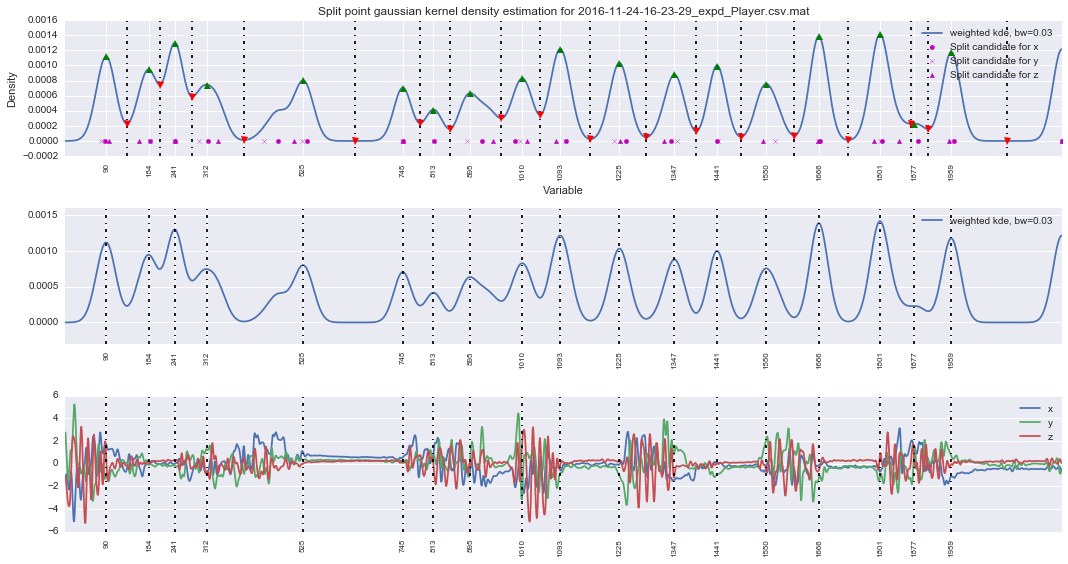

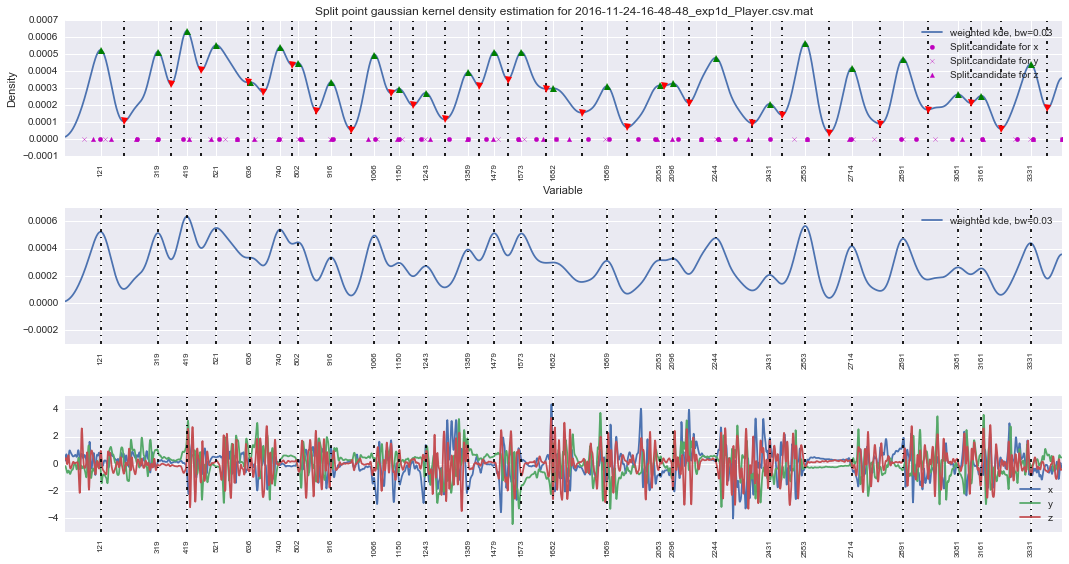

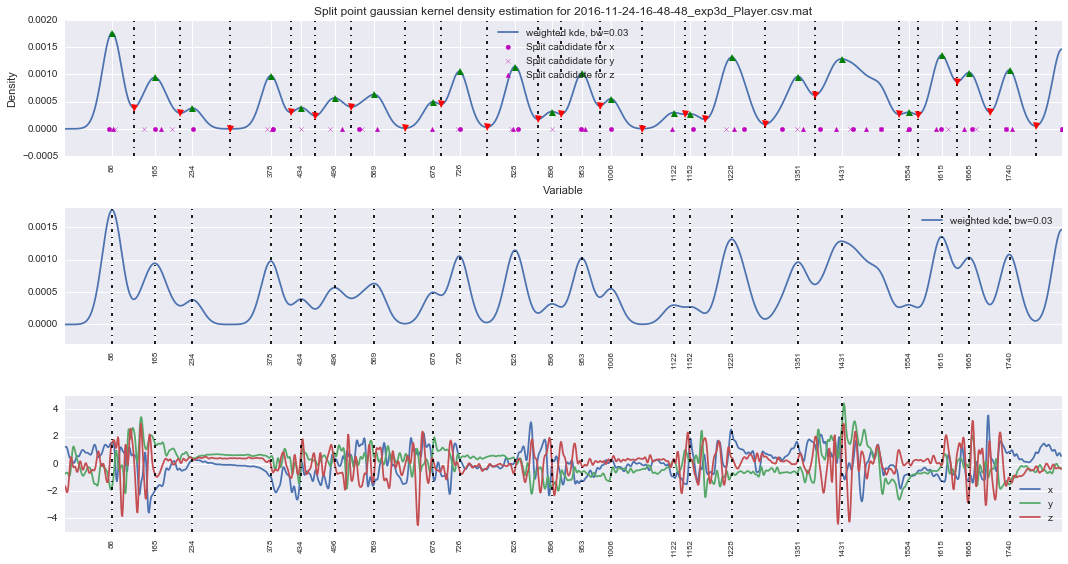

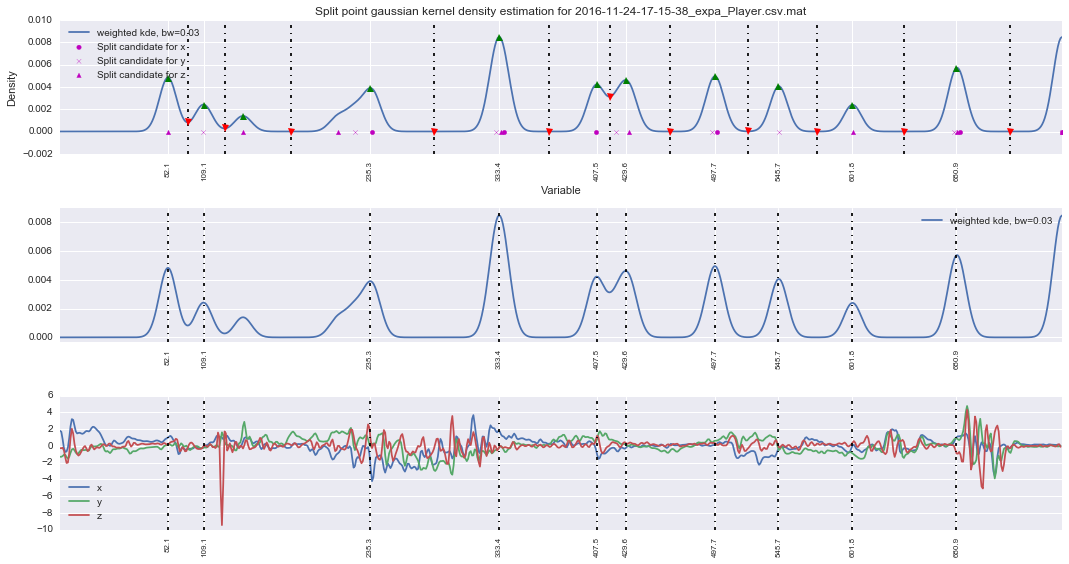

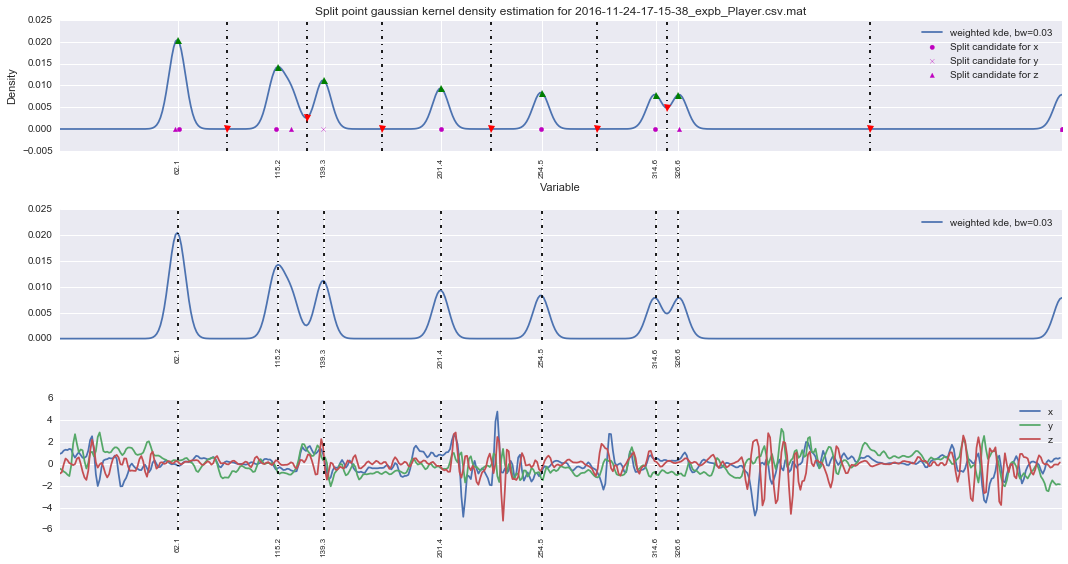

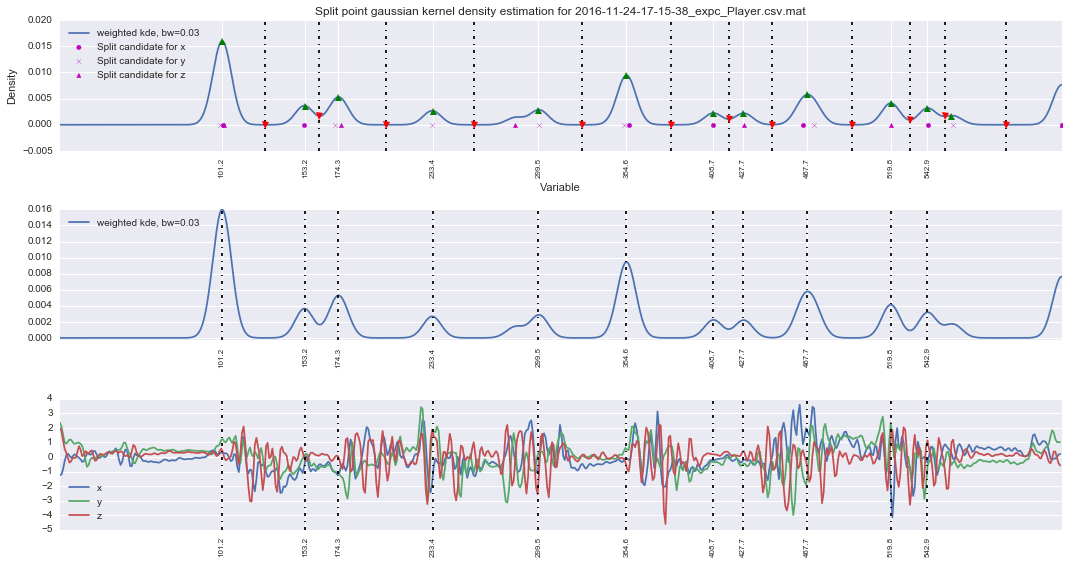

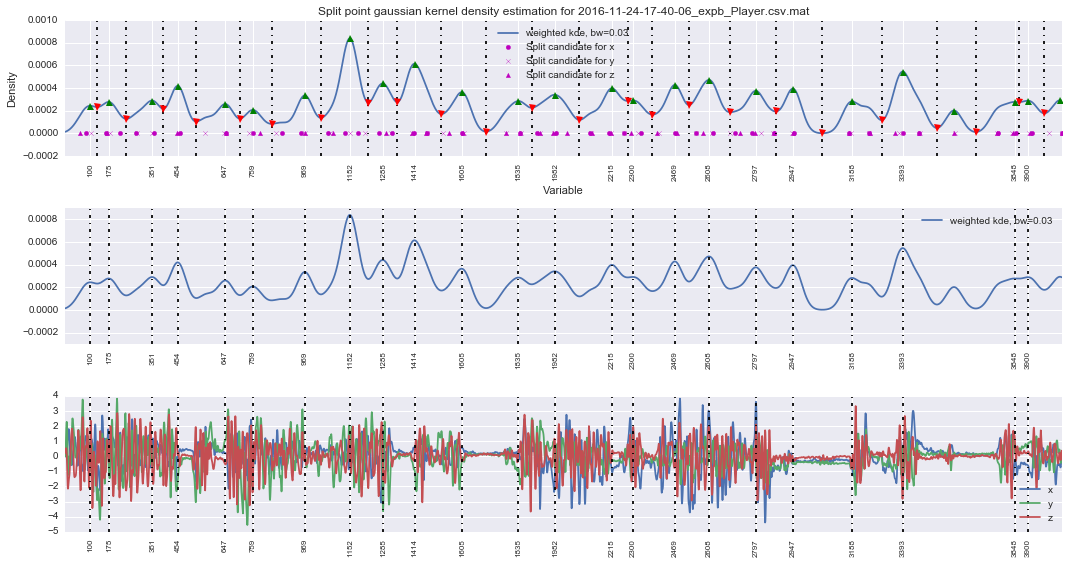

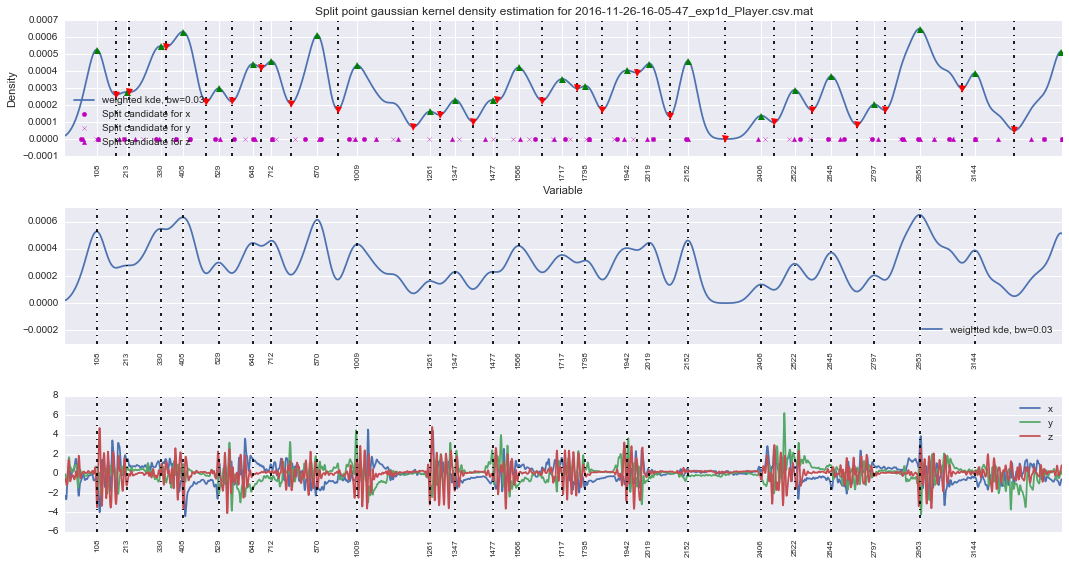

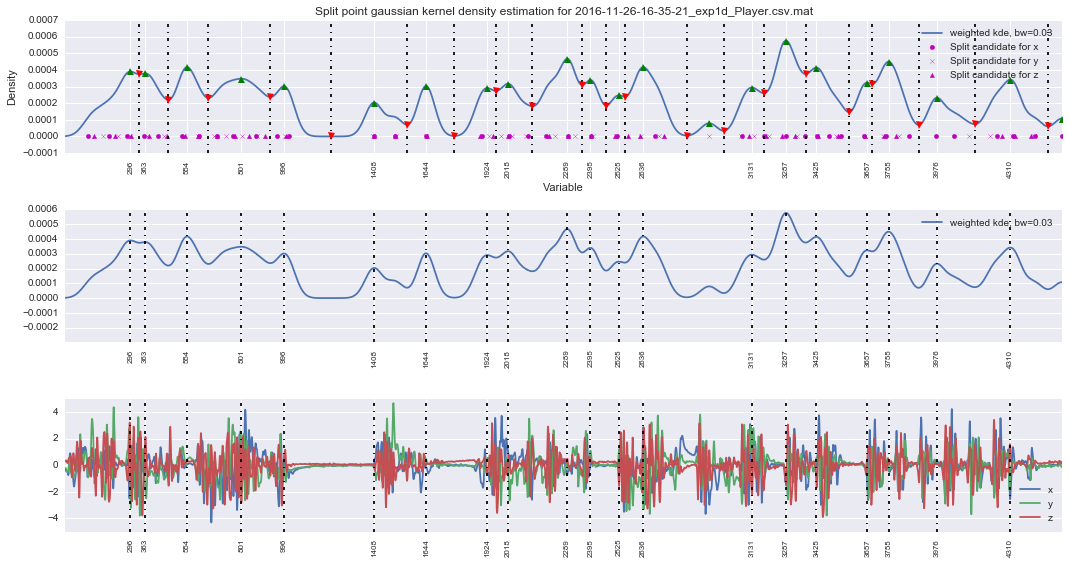

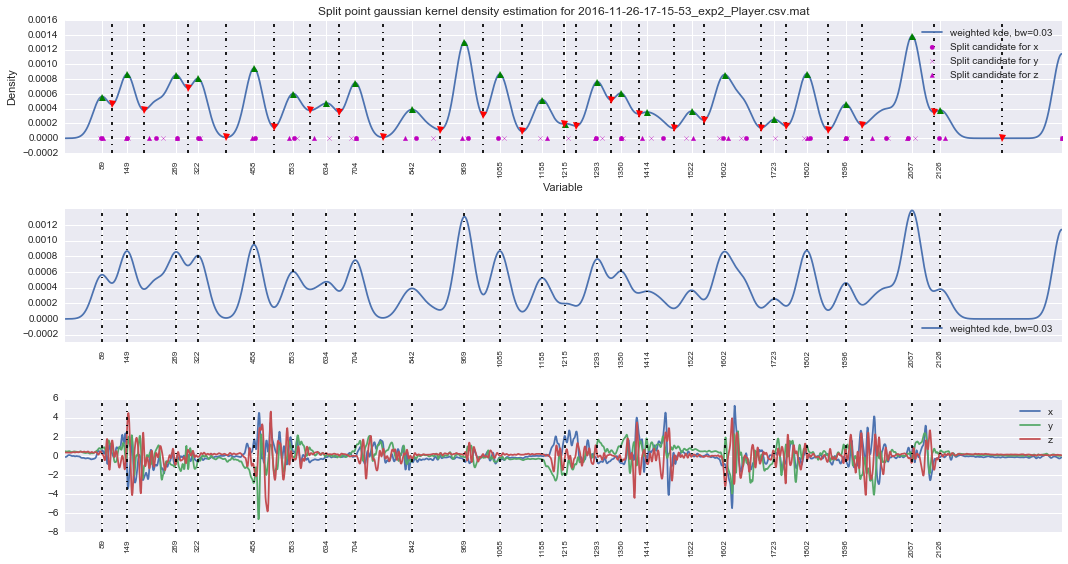

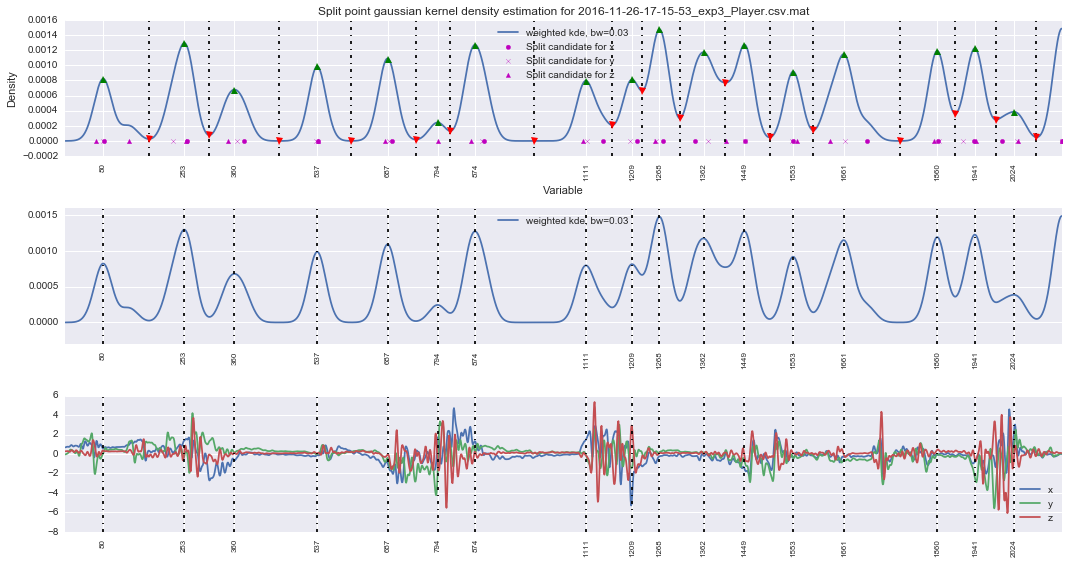

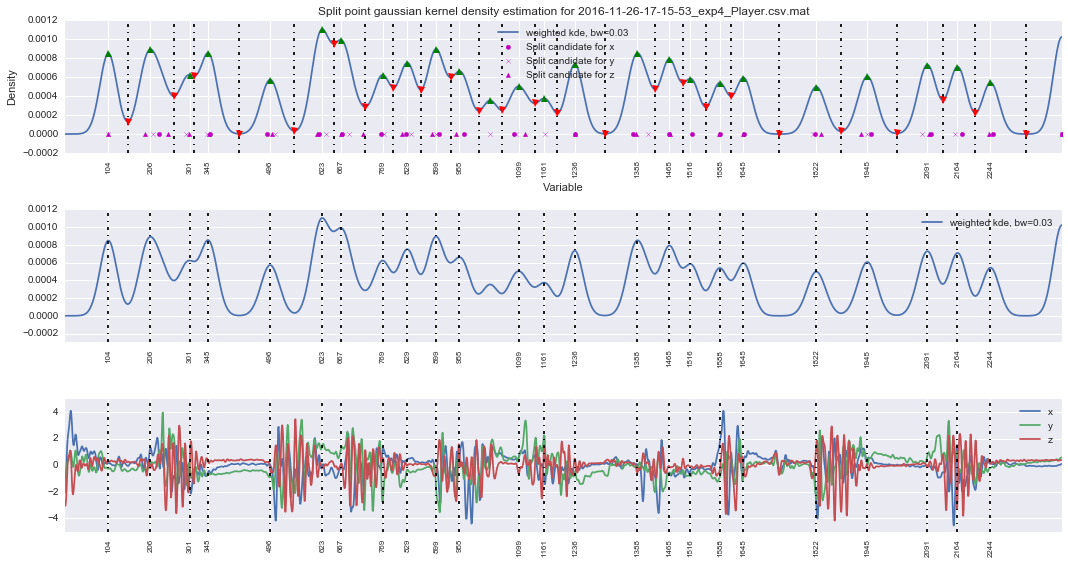

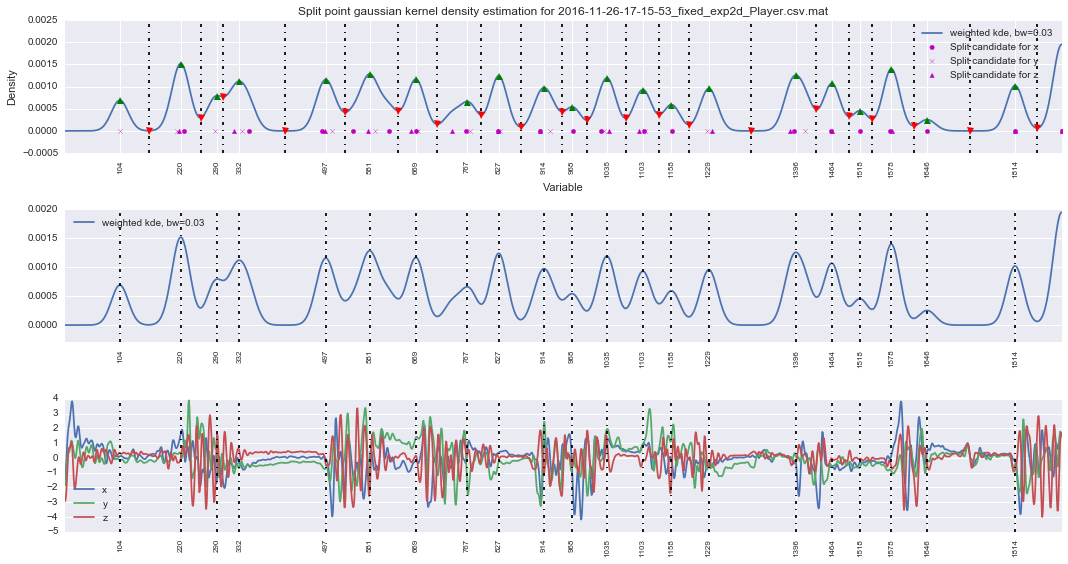

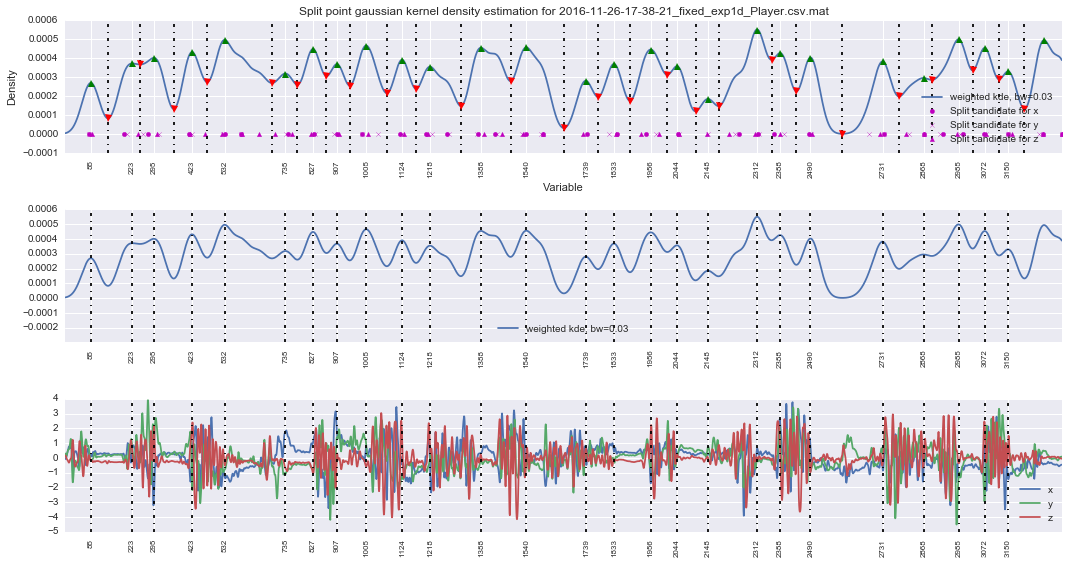

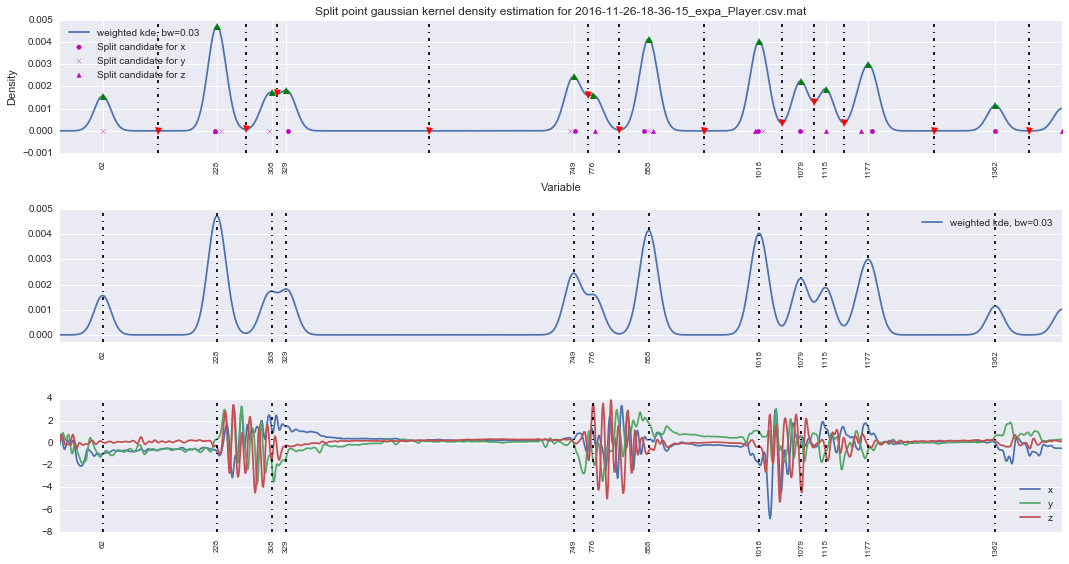

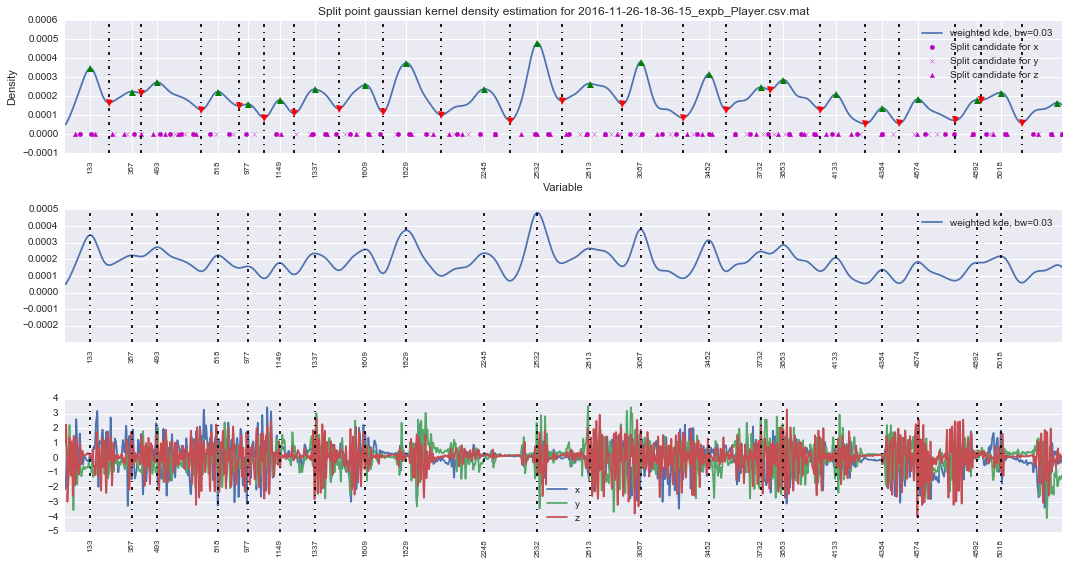

In [6]:
ma_mi_list = {}
cluster_centers = {}
tau = 1#0.95
for ind, current_file in enumerate(dataset.keys()):
    fig=figure(figsize=(15,8))
    ax1=fig.add_subplot(311)
    
    split_cand_list = []
    weigth_list = []
    data = dataset[current_file]
    for axis in acc_axes:
        split_cand_list += [(s,axis) for s in data[axis+'.splits']]
        weigth_list     += [(w,axis) for w in data[axis+'.weights']]

    weights = np.array([w[0] for w in weigth_list], np.float)
    samples = np.array([s[0] for s in split_cand_list])

    min, max = 0,len(data['x.ts'])
    x = np.linspace(min, max, max)

    clusters = []

    #Construct a KDE and plot it
    bws = [0.03]#0.01, 0.02, 0.03, 0.06, 0.1]
    ma = None
    mi = None
    for bw in bws:
        pdf = gaussian_kde(samples, bw_method=bw, weights=weights)
        y = pdf(x)
        ax1.plot(x, y, label='weighted kde, bw='+ str(bw))
        # mi = list of minimum indices in y.
        # ma = list of maximum indices in y.
        mi, ma = argrelextrema(y, np.less)[0], argrelextrema(y, np.greater)[0]
        #print "Minima:", x[mi]
        #print "Maxima:", x[ma]

        samples2 = []
        for s,w in zip(split_cand_list,weigth_list):
            samples2.append((s[0],w[0],s[1]))
        samples2 = np.array(samples2)

        for xc in x[mi]:
            ax1.axvline(x=xc, color='k', linestyle='-.')

        ## Get clusters by considering each one as a region between minimas. 
        # Count the itens for each cluster region. O(K), where K are regions defined by minimas.
        for m in range(len(mi)):
            if m == 0:
                clusters.append(samples2[samples < x[mi[m]]].tolist())
            else:
                clusters.append(samples2[(samples >= x[mi[m-1]]) * (samples <= x[mi[m]])].tolist())

        ax1.plot(x[ma], y[ma], 'g^',x[mi], y[mi], 'rv')

    ## Saving maxima e minima
    ma_mi_list[current_file] = {'mi': mi, 'ma': ma}
    
    energies = []
    total_energy = 0
    for ind,c in enumerate(clusters):
        accumulator = 0
        for elem in c:
            accumulator += float(elem[1])
        total_energy += accumulator
        energies.append((accumulator,ind))

    #energies = [(e/total_energy,ind) for inx,e in enumerate(energies)]

    #print 'Total energy: {}'.format(total_energy)
    #print 'Total energy after normalization: {}'.format(sum([e[0] for e in energies]))
    energies.sort(reverse=True, key=lambda tup: tup[0])

    #Plot the split candidates
    markers = ['o','x','^']
    colors = ['b', 'r','m']
    for i,axis in enumerate(acc_axes):
        ax1.scatter(data[axis+'.splits'], np.zeros_like(data[axis+'.splits']),
                    label='Split candidate for {}'.format(axis),
                    marker=markers[i], color='m')

    #Boiler plate
    plt.xticks([s[0] for s in split_cand_list],rotation = 90, fontsize=8)
    ax1.set_title('Split point gaussian kernel density estimation for {}'.format(current_file))
    ax1.set_xlabel('Variable')
    ax1.set_ylabel('Density')
    plt.legend(loc='best', frameon=False)

    final_clusters = []
    accumulator = 0
    for e in energies:
        accumulator += e[0]
        if accumulator > tau*total_energy:
            break
        else:
            final_clusters.append(e[1])

    #print 'Total: {}, Accumulator: {}, Threshold: {}'.format(total_energy,accumulator,tau*total_energy)
    cluster_centers[current_file] = x[ma[final_clusters]]

    ax2 = fig.add_subplot(312, sharex=ax1)
    ax2.plot(x, y, label='weighted kde, bw='+ str(bw))
    for xc in x[ma[final_clusters]]:
            ax2.axvline(x=xc, color='k', linestyle='-.')
    ax2.set_ylim(-0.0003,ax2.get_ylim()[1])
    plt.xticks([s[0] for s in split_cand_list],rotation = 90, fontsize=8)
    plt.legend(loc='best', frameon=False)

    ax3 = fig.add_subplot(313, sharex=ax1)
    for axis in acc_axes:
        ax3.plot(data[axis+'.ts'], label=axis)

    for xc in x[ma[final_clusters]]:
        ax3.axvline(x=xc, color='k', linestyle='-.')     

    plt.xticks(x[ma[final_clusters]],rotation = 90, fontsize=8)
    plt.legend(loc='best', frameon=False)
    plt.tight_layout()
    #plt.ylim(-0.0003,plt.ylim()[1])
    plt.xlim(min,max)
    plt.show()

## Getting the segments

In [26]:
def get_segments(filename,maximas):
    data = dataset[filename]
    x_segments = []
    y_segments = []
    z_segments = []
    alignments = []
    
    min, max = 0,len(data['x.ts'])
    x = np.linspace(min, max, max)
    
    centers = [int(i) for i in sorted(cluster_centers[filename])]
    x_data = np.array(data['x.ts'])
    y_data = np.array(data['y.ts'])
    z_data = np.array(data['z.ts'])
    for i in range(len(centers)):
            if i == 0:
                x_segments.append(x_data[:int(centers[i])])
                y_segments.append(y_data[:int(centers[i])])   
                z_segments.append(z_data[:int(centers[i])])
                alignments.append(0)
            elif i == (len(centers)-1):
                x_segments.append(x_data[int(centers[i-1]):int(centers[i])].tolist())
                x_segments.append(x_data[int(centers[i]):].tolist())
                y_segments.append(y_data[int(centers[i-1]):int(centers[i])].tolist())
                y_segments.append(y_data[int(centers[i]):].tolist())
                z_segments.append(z_data[int(centers[i-1]):int(centers[i])].tolist())
                z_segments.append(z_data[int(centers[i]):].tolist())

                alignments.append(centers[i-1])
                alignments.append(centers[i])
            else:
                x_segments.append(x_data[int(centers[i-1]):int(centers[i])].tolist())
                y_segments.append(y_data[int(centers[i-1]):int(centers[i])].tolist())
                z_segments.append(z_data[int(centers[i-1]):int(centers[i])].tolist())
                alignments.append(centers[i-1])
    return x_segments, y_segments, z_segments, alignments

## Checking data segments equality with original time series.

In [27]:
x_segments = []
y_segments = []
z_segments = []
alignments = []
file_map_list   = []

for f in dataset.keys():
    x_seg, y_seg, z_seg, aligns = get_segments(f,ma_mi_list[f]['ma'])
    ### testing equality
    try:
        assert list(itertools.chain.from_iterable(x_seg)) == dataset[f]['x.ts']
        assert list(itertools.chain.from_iterable(y_seg)) == dataset[f]['y.ts']
        assert list(itertools.chain.from_iterable(z_seg)) == dataset[f]['z.ts']
    except AssertionError:
        _, _, tb = sys.exc_info()
        traceback.print_tb(tb) # Fixed format
        tb_info = traceback.extract_tb(tb)
        filename, line, func, text = tb_info[-1]
        print('An error occurred on line {} in statement {}'.format(line, text))
        print('Equivalence test failed for file {}. ABORTING'.format(f))
        break
    
    for i in range(len(x_seg)):
        x_segments.append(x_seg[i])
        y_segments.append(y_seg[i])
        z_segments.append(z_seg[i])
        alignments.append(aligns[i])
        file_map_list.append('.'.join(f.split('.')[:-1]))
    
print 'ALL files PASSED on equivalence tests. This means the segmentation does not lose data!'

ALL files PASSED on equivalence tests. This means the segmentation does not lose data!


## Framming corpus

In [28]:
df = {
      'x'    : x_segments,
      'y'    : y_segments,
      'z'    : z_segments,
      'align' : alignments,
      'file' : file_map_list
     }

frame = pd.DataFrame(df, index = [range(len(file_map_list))] , columns = ['x','y','z','align','file'])

## Exporting model to pickle.

In [29]:
# open the file for writing
pkl_file_name = 'segments.pkl'
file_object = open(pkl_file_name,'wb')
pickle.dump(frame,file_object)
file_object.close()
print 'pickle DONE!'

pickle DONE!


## Plot by segment

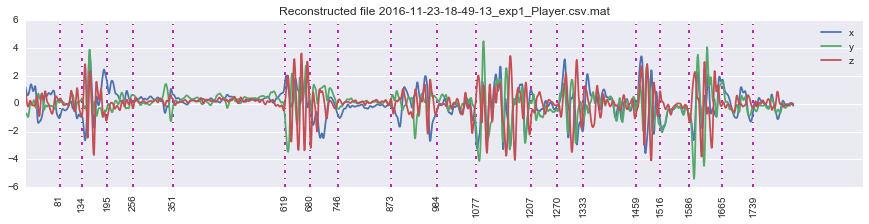

In [44]:
figure(figsize=(15,3))
filename = dataset.keys()[0]
for xc in cluster_centers[filename]:
    plt.axvline(x=xc, color='m', linestyle='-.')

x = list(itertools.chain.from_iterable(frame.loc[frame['file'] == '.'.join(filename.split('.')[:-1])]['x'].tolist()))
y = list(itertools.chain.from_iterable(frame.loc[frame['file'] == '.'.join(filename.split('.')[:-1])]['y'].tolist()))
z = list(itertools.chain.from_iterable(frame.loc[frame['file'] == '.'.join(filename.split('.')[:-1])]['z'].tolist()))
plt.plot(x,'-', label='x')
plt.plot(y, '-', label='y')
plt.plot(z, '-', label='z')
plt.title("Reconstructed file {}".format(filename))
plt.legend()
plt.xticks(cluster_centers[filename], rotation = 90)
#plt.ylim(-6,6)
plt.show()